In [ ]:
!pip install opencv-python numpy

In [1]:
import cv2
import numpy as np
import json
import glob

In [2]:
CHECKERBOARD = (8, 6) 

In [3]:
image_files = sorted(glob.glob("chessboard_dataset/*.jpeg"))

In [ ]:

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)


objpoints = []  # 3d points in the world coordinate system
imgpoints = []  # 2d points in the image plane

for fname in image_files:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    if ret:
        
        corners_subpix = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), criteria
        )
        
        
        objpoints.append(objp)
        imgpoints.append(corners_subpix)
        
        
        cv2.drawChessboardCorners(img, CHECKERBOARD, corners_subpix, ret)
        


In [ ]:

img_shape = cv2.imread(image_files[0]).shape
h, w = img_shape[:2]


ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, (w, h), None, None
)

print("Calibration was successful?", ret)  # ret is the overall RMS re-projection error
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Coeffs:\n", distCoeffs)


Calibration was successful? 0.5090677847546905
Camera Matrix:
 [[956.63717905   0.         369.05488009]
 [  0.         957.55139544 651.41419152]
 [  0.           0.           1.        ]]
Distortion Coeffs:
 [[ 0.19763675 -0.70686389  0.00336937  0.00698244  0.04877254]]


In [8]:
print("Mean reprojection error = ", ret)


Mean reprojection error =  0.5090677847546905


In [9]:
rotation_mats = []
for rvec in rvecs:
    R, _ = cv2.Rodrigues(rvec)
    rotation_mats.append(R)

In [ ]:
import json



k1 = distCoeffs[0, 0]
k2 = distCoeffs[0, 1]
p1 = distCoeffs[0, 2]  # tangential
p2 = distCoeffs[0, 3]  # tangential
k3 = distCoeffs[0, 4]


radial_coeffs = [ float(k1), float(k2), float(k3) ]


fx = cameraMatrix[0, 0]
fy = cameraMatrix[1, 1]
skew = cameraMatrix[0, 1] 
cx = cameraMatrix[0, 2]
cy = cameraMatrix[1, 2]



all_errors = []
for i in range(len(objpoints)):
    
    corners2, _ = cv2.projectPoints(
        objpoints[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs
    )
    
    diff = corners2.reshape(-1,2) - imgpoints[i].reshape(-1,2)
    err = np.sqrt((diff**2).sum(axis=1))  
    all_errors.extend(err.tolist())
mean_error = np.mean(all_errors)
std_dev = np.std(all_errors)





extrinsics_list = []
for i, (R, t) in enumerate(zip(rotation_mats, tvecs), start=1):
    
    R_list = R.tolist()
    t_list = t.ravel().tolist()  
    extrinsics_list.append({
        "image_id": i,
        "rotation_matrix": R_list,
        "translation_vector": t_list
    })


calib_data = {
    "intrinsic_parameters": {
        "focal_length": [float(fx), float(fy)],
        "skew": float(skew),
        "principal_point": [float(cx), float(cy)]
    },
    "extrinsic_parameters": extrinsics_list,
    "radial_distortion_coefficients": radial_coeffs,
    "reprojection_errors": {
        "mean_error": mean_error,
        "std_dev": std_dev  
    }
}

with open("2021282_parameters.json", "w") as f:
    json.dump(calib_data, f, indent=4)


In [11]:
import os

output_folder = "undistorted_samples"
os.makedirs(output_folder, exist_ok=True)

for i, fname in enumerate(image_files[:5], start=1):
    img = cv2.imread(fname)
    undistorted = cv2.undistort(img, cameraMatrix, distCoeffs)
    outname = os.path.join(output_folder, f"undistorted_{i}.jpg")
    cv2.imwrite(outname, undistorted)


“After applying the estimated radial distortion coefficients, we undistorted five raw images. Because the lens in our device is not strongly wide‐angled, the geometric change near the edges is relatively subtle. Nonetheless, closer inspection (especially near image corners) shows slightly straighter horizontal/vertical lines compared to the original images.”

Per-image errors: [0.2663171, 0.2759759, 0.51571685, 0.60863924, 0.53886455, 0.43892765, 0.51803553, 0.2763334, 0.25553098, 0.29681656, 0.39105615, 0.6767886, 0.29864118, 0.30683938, 0.5507497, 0.42796347, 0.21358149, 0.38495126, 0.4160246, 0.36440995, 0.57891196, 0.34996328, 0.57292753, 0.28274298, 0.6025495]
Mean Reprojection Error =  0.41637036
Std Deviation of Error =  0.13264434


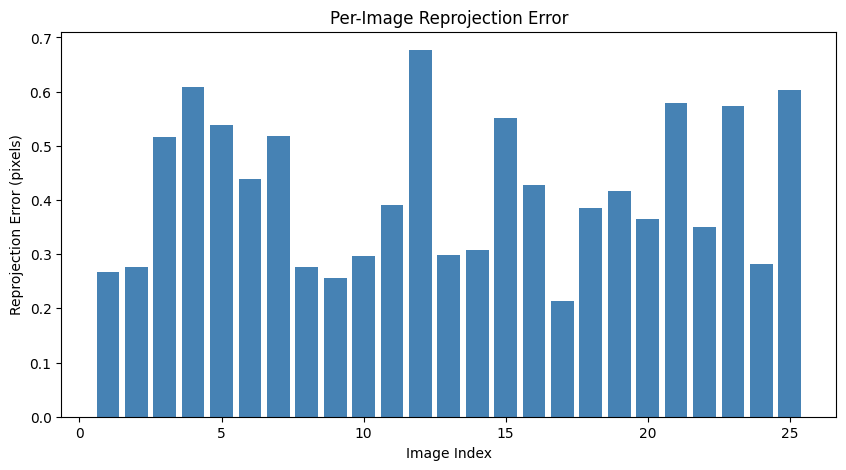

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



per_image_errors = []

for i in range(len(objpoints)):

    projected_points, _ = cv2.projectPoints(
        objpoints[i], rvecs[i], tvecs[i],
        cameraMatrix, distCoeffs
    )
    
    projected_points = projected_points.reshape(-1, 2)
    detected_points = imgpoints[i].reshape(-1, 2)

    
    diff = projected_points - detected_points
    errors = np.linalg.norm(diff, axis=1)  
    mean_error = np.mean(errors)
    per_image_errors.append(mean_error)


mean_error_all = np.mean(per_image_errors)
std_error_all = np.std(per_image_errors)

print("Per-image errors:", per_image_errors)
print("Mean Reprojection Error = ", mean_error_all)
print("Std Deviation of Error = ", std_error_all)


plt.figure(figsize=(10,5))
plt.bar(range(1, len(per_image_errors)+1), per_image_errors, color='steelblue')
plt.xlabel('Image Index')
plt.ylabel('Reprojection Error (pixels)')
plt.title('Per-Image Reprojection Error')
plt.show()


In [ ]:
import os

overlay_folder = "corner_overlays"
os.makedirs(overlay_folder, exist_ok=True)

for i in range(len(objpoints)):
    img = cv2.imread(image_files[i])
    
    projected_points, _ = cv2.projectPoints(
        objpoints[i], rvecs[i], tvecs[i],
        cameraMatrix, distCoeffs
    )
    projected_points = projected_points.reshape(-1,2)

    
    detected_points = imgpoints[i].reshape(-1,2)


    for (dx, dy) in detected_points:
        cv2.circle(img, (int(dx), int(dy)), 5, (0,255,0), -1)

    
    for (px, py) in projected_points:
        cv2.circle(img, (int(px), int(py)), 3, (0,0,255), -1)

    out_name = os.path.join(overlay_folder, f"corner_overlay_{i+1}.jpg")
    cv2.imwrite(out_name, img)


“The re-projection error is computed by taking each detected 2D corner (x_det, y_det), projecting its corresponding 3D point using the estimated camera parameters to get (x_proj, y_proj), and measuring their Euclidean distance. This error is then averaged across all corners in an image to give a per-image metric, and further averaged across all images to get a global mean.”

In [ ]:
import numpy as np

plane_normals_camera = []

for i, R in enumerate(rotation_mats):
    
    normal_cam = R[:, 2]  
    
    normal_cam = normal_cam / np.linalg.norm(normal_cam)
    plane_normals_camera.append(normal_cam)

    print(f"Image {i+1}: plane normal in camera frame = {normal_cam}")


Image 1: plane normal in camera frame = [-0.07616832 -0.14870444  0.9859439 ]
Image 2: plane normal in camera frame = [-0.02286982  0.12383014  0.99203985]
Image 3: plane normal in camera frame = [-0.39826969 -0.18715469  0.89797237]
Image 4: plane normal in camera frame = [-0.34643455 -0.5281008   0.77530165]
Image 5: plane normal in camera frame = [0.35820574 0.39861418 0.8442721 ]
Image 6: plane normal in camera frame = [ 0.04521851 -0.32517343  0.94457267]
Image 7: plane normal in camera frame = [-0.127789   -0.50726444  0.85226331]
Image 8: plane normal in camera frame = [0.07201333 0.21723429 0.97345947]
Image 9: plane normal in camera frame = [-0.09543047  0.19721068  0.97570537]
Image 10: plane normal in camera frame = [-0.14608073  0.07386587  0.98651115]
Image 11: plane normal in camera frame = [-0.10773352 -0.08642538  0.99041615]
Image 12: plane normal in camera frame = [-0.3852682  -0.30920821  0.86945885]
Image 13: plane normal in camera frame = [-0.13551126 -0.10599323  